In [1]:
# import libraries

# Data manipulation
import numpy as np
import pandas as pd
import re

# Data visualisation
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.axes as ax

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
data = pd.read_excel('CompanyA-RetailCorpus-unprotected.xlsx')
data.head()

,Outlet,Order Date,Item,Item Name,Qty,Sales
0,WG,2018-11-10,FS0201823020000CF,KONTUR CHAIR,4,916.00
1,WG,2018-11-10,FS0200039020300DW,ROND DINING TABLE 150 X 80 X 74 CM,1,1167.55
2,WG,2018-11-10,FS0205112020000KF,LOIS DINING TABLE 135 CM - SOLID (1 FOLD X 24 MM),1,1399.00
3,WG,2018-12-08,BS0302778030100MA,3FT SINGLE BED WITH BEDSLATS,1,369.00
4,WG,2018-12-08,FS0308195030100MF,3FT SPINAL CARE MATTRESS,1,263.12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34835 entries, 0 to 34834
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Outlet      34835 non-null  object        
 1   Order Date  34835 non-null  datetime64[ns]
 2   Item        34835 non-null  object        
 3   Item Name   34835 non-null  object        
 4   Qty         34835 non-null  int64         
 5   Sales       34835 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
data.nunique()

Outlet          19
Order Date     759
Item           677
Item Name      612
Qty             17
Sales         3214
dtype: int64

## Time Series Analysis

In [5]:
data['Order Date'].describe()

# 2 years 1 month period

<ipython-input-5-28fdcd282d63>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                   34835
unique                    759
top       2019-01-06 00:00:00
freq                      324
first     2018-09-01 00:00:00
last      2020-09-30 00:00:00
Name: Order Date, dtype: object

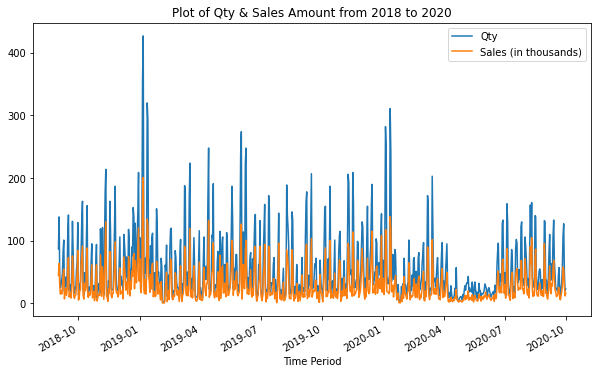

In [6]:
# quantity of item purchased
gb_time = pd.DataFrame(data.groupby('Order Date').Qty.sum())

# purchase amount
amt = data.groupby('Order Date').Sales.sum()/1000
gb_time['Sales'] = amt
gb_time = gb_time.rename(columns={'Sales':'Sales (in thousands)'})
gb_time.reset_index(inplace=True)

# line graphs of both quantity and purchase amounts 
gb_time.plot(x='Order Date', y=['Qty', 'Sales (in thousands)'], figsize=(10,6))
plt.title("Plot of Qty & Sales Amount from 2018 to 2020")
plt.xlabel("Time Period");

In [7]:
amt.sort_values(ascending=False)

Order Date
2019-01-06    200.91539
2019-01-05    164.01025
2020-01-11    138.36537
2019-01-12    134.32560
2019-04-14    132.31859
                ...    
2019-07-25      0.83287
2019-02-06      0.79800
2019-02-07      0.73600
2019-02-04      0.58900
2020-01-26      0.56568
Name: Sales, Length: 759, dtype: float64

### Some Observations
- High sales especially in the beginning of both years (2019 and 2020)
- Highest sales on the first weekend of 2019
- Longest low sales period occurred in mid 2020, when the pandemic took a turn for the worst

## Outlet Analysis

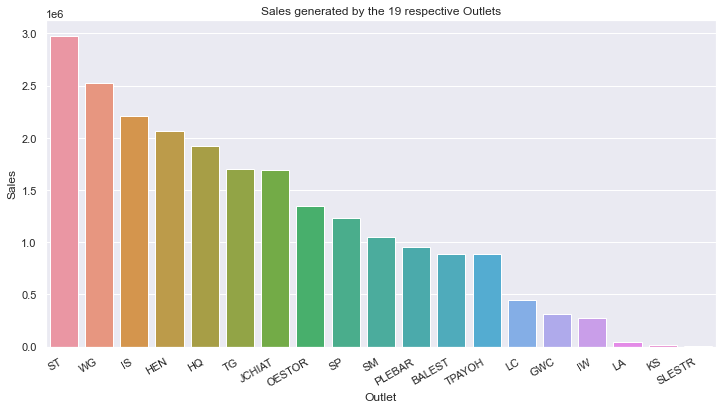

In [8]:
outlets = data.groupby('Outlet')['Sales'].sum().sort_values(ascending=False)
outlets = outlets.to_frame().reset_index()

sns.set(rc={'figure.figsize':(12,6)})
ax = sns.barplot(x='Outlet', y='Sales', data=outlets)
ax.set_title('Sales generated by the 19 respective Outlets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');

- Suntec City and Westgate outlets generate the most sales
- E-stores Scanliving and KrisShop generate the least sales

## Item Purchases

In [9]:
gb_item = data[['Item', 'Item Name']].groupby('Item').agg({'Item Name':set})
gb_item[gb_item['Item Name'].apply(len) > 1]

,Item Name
Item,
FS0200816020000RS,"{OCCASIONAL STAND, REKKI 3 LAYER OPEN SHELF}"
FS0500029050000MA,{REKKI 3 LAYER OPEN SHELF ...


In [10]:
gb_item_name = data[['Item', 'Item Name']].groupby('Item Name').agg({'Item':set})
gb_item_name[gb_item_name['Item'].apply(len) > 1].head()

,Item
Item Name,
1 DOOR WARDROBE WITH 2 PCS ROD (W/ DOOR),"{BS0307005030601NA, BS0307008030601NA}"
1 DOOR WARDROBE WITH 3 PCS SHELVES (W/ DOOR),"{BS0307008030600NA, BS0305008030600NA, BS03070..."
2 DOOR WARDROBE (C/W 1PC SHELF + 1PC ROD + 1 SET DRAWER),"{BS0305005030700NA, BS0307008030700NA, BS03070..."
2 DOOR WARDROBE (C/W 2PC ROD + 1 PC SHELF),"{BS0307005030701NA, BS0307013030701NA, BS03050..."
3.5FT SPINAL CARE MATTRESS,"{FS0307195030200MF, FS0308195030200MF}"


- 2 item codes are used for >1 item names each (i.e. some item names have the same item code)
- quite a lot of item names have multiple item codes 
- 'Item' is more unique than 'Item Name'

### Item Feature Engineering

In [11]:
def category(name):
    """splitting items into categories of furniture (places in house) from item names"""
    name = name.lower().split()
    dining = ['dining', 'fork', 'spoon', 'bowl', 'tray', 'teapot', 'bar', "chef's", 'microwave']
    bedroom = ['bed', 'daybed', 'bedside', 'bedslats', 'mattress', 'pocket-coil', 'wardrobe', 'sleep', 'pillow', 'dresser', 'dressing']
    office = ['office', 'writing', 'study', 'desk', 'secretary', 'computer', 'laptop']
    storage = ['shelf', 'shelve', 'shelves', 'bookcase', 'drawer', 'drawers', 'hanger', 'chest', 'divider', 'sideboard', 'shoe', 'shoes', 'cabinet']
    living = ['tv', 'sofa', 'cushion', 'seater', 'stool', 'table', 'chair', 'bench', 'console', 'ottoman']
    if np.setdiff1d(dining, name).size < len(dining): # at least 1 word matched
        return 'Dining Room'
    elif np.setdiff1d(bedroom, name).size < len(bedroom):
        return 'Bedroom'
    elif np.setdiff1d(office, name).size < len(office):
        return 'Home Office'
    elif np.setdiff1d(storage, name).size < len(storage):
        return 'Storage'
    elif np.setdiff1d(living, name).size < len(living): # rest of tables and chairs should belong here
        return 'Living Room'
    else: # display stands, covers, mirror, panel
        return 'Others'
    
def dimensions(name):
    """extracting dimensions or size of furniture from item names"""
    if bool(re.search('\d*[.]*\dFT', name)): # ft measurement
        return re.findall('\d*[.]*\dFT', name)[0]
    elif ('CM' in name) | ('MM' in name): # cm/mm dimensions
        try:
            return re.findall('((\d+\s?X\s?)*\d+\s?[CM]M)', name)[0][0]
        except:
            return 'no dim'
    elif bool(re.search('\d[-\s]SEATER', name)): # number of seats
        return re.findall('\d[-\s]SEATER', name)[0][0] + ' SEATER'
    else:
        return 'no dim'
    
data['Category'] = data['Item Name'].apply(category)
data['Dimensions'] = data['Item Name'].apply(dimensions)
data.head(10)

,Outlet,Order Date,Item,Item Name,Qty,Sales,Category,Dimensions
0,WG,2018-11-10,FS0201823020000CF,KONTUR CHAIR,4,916.00,Living Room,no dim
1,WG,2018-11-10,FS0200039020300DW,ROND DINING TABLE 150 X 80 X 74 CM,1,1167.55,Dining Room,150 X 80 X 74 CM
2,WG,2018-11-10,FS0205112020000KF,LOIS DINING TABLE 135 CM - SOLID (1 FOLD X 24 MM),1,1399.00,Dining Room,135 CM
3,WG,2018-12-08,BS0302778030100MA,3FT SINGLE BED WITH BEDSLATS,1,369.00,Bedroom,3FT
4,WG,2018-12-08,FS0308195030100MF,3FT SPINAL CARE MATTRESS,1,263.12,Bedroom,3FT
5,WG,2018-12-08,FS0500087050000PT,OKA DISPLAY STAND (30X30X45CM),1,122.32,Others,30X30X45CM
6,WG,2018-12-08,BS0103316010204RK,ENKEL 2-SEATER WITH CUSHION & COVER #KB1710-06,1,799.00,Living Room,2 SEATER
7,WG,2018-12-08,FS0200337020000RK,BASS DINING CHAIR,1,201.52,Dining Room,no dim
8,WG,2018-12-08,BS0103316010204RK,ENKEL 2-SEATER WITH CUSHION & COVER #KB1710-06,2,1598.00,Living Room,2 SEATER
9,WG,2018-12-08,FS0201825020000KF,KORTA OCCASIONAL SIDE TABLE,3,261.36,Living Room,no dim


In [12]:
data.to_excel('edit-CompanyA-RetailCorpus.xlsx')

## Item-based / Product-Product Recommender System

In [13]:
tfidf = TfidfVectorizer(stop_words='english')
# construct TF-IDF matrix by applying the fit_transform method on the item name/desc
items = pd.Series(data['Item Name'].unique())
item_matrix = tfidf.fit_transform(items)
item_matrix.shape

(612, 648)

In [14]:
# compute similarity between item names, similar to cosine similarity
# values 0 to 1
similarity_matrix = linear_kernel(item_matrix,item_matrix)
similarity_matrix

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.17211879, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17211879, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [15]:
mapping = pd.Series(items.index, index = items)
mapping

KONTUR CHAIR                                                      0
ROND DINING TABLE 150 X 80 X 74 CM                                1
LOIS DINING TABLE 135 CM - SOLID (1 FOLD X 24 MM)                 2
3FT SINGLE BED WITH BEDSLATS                                      3
3FT SPINAL CARE MATTRESS                                          4
                                                               ... 
3FT PEDIC COOL MATTRESS                                         607
3 SEATER COVER #14113 #G113                                     608
2 SEATER COVER #14113 #G113                                     609
ISLAND DAYBED CUSHION CW (1S+2B) #1623-18+1 BOLSTER#1623-19     610
REKKI 3 LAYER OPEN SHELF                                        611
Length: 612, dtype: int64

In [16]:
def recommend(item_input):
    index = mapping[item_input]
    
    # get similarity values with other items
    similarity_score = list(enumerate(similarity_matrix[index])) # list of index and similarity score
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True) # descending order of scores
    # top 10 most similar item names
    similarity_score = similarity_score[1:11] # index 0 is the item itself
#     print(similarity_score)
    
    item_indices = [i[0] for i in similarity_score]
    return items.iloc[item_indices]

In [17]:
recommend('3FT PEDIC COOL MATTRESS')
# reco 2 and 3: 5FT and 3.5FT same similarity score

134                 3FT BACK PEDIC MATTRESS
85                  5FT BACK PEDIC MATTRESS
137               3.5FT BACK PEDIC MATTRESS
290                 6FT BACK PEDIC MATTRESS
176                  3FT ORTHOREST MATTRESS
175                 3FT FLEXI COIL MATTRESS
57                3FT POSTURE REST MATTRESS
4                  3FT SPINAL CARE MATTRESS
419    3FT KOMFORT AIR MATTRESS-91X188X15CM
132                   3FT BED WITH BEDSLATS
dtype: object

In [18]:
recommend('ROND DINING TABLE 150 X 80 X 74 CM')

116                   ROND DINING TABLE 135 X 80 X 74 CM
77     LOIS DINING TABLE 150 CM - SOLID (1 FOLD X 24 MM)
266                                 HYLLA BOOKCASE 80 CM
600              LOIS DINING TABLE FJL (150 X 90 X 74CM)
160                  LYFT FOLDING TABLE (80 X 80 X 75CM)
576                            CHAIR 3 (49 X 46 X 80 CM)
388              LOIS DINING TABLE FJL (135 X 80 X 74CM)
42     MONO DINING TABLE-150 X 75 X 72CM-SCANTEAK FUR...
361                            SLANK 135 CM DINING TABLE
550                   CHAIR 2 WITH ARM (49 X 46 X 80 CM)
dtype: object

In [19]:
recommend('KORS 3 SEATER FRAME WITH CUSHION & COVER #25B (NEW SOFTNESS)')
# similarity score same if difference is only the digits eg. 3 SEATER COVER VS 1 SEATER COVER

93     KORS 1 SEATER FRAME WITH CUSHION & COVER #25B ...
213    KORS 2 SEATER FRAME WITH CUSHION & COVER #25B ...
509      LINEAR 2-SEATER FRAME WITH CUSHION & COVER #25B
18                                        3 SEATER COVER
94                                        1 SEATER COVER
130                                       2 SEATER COVER
105                                     3 SEATER CUSHION
124                                     1 SEATER CUSHION
168                                     2 SEATER CUSHION
294    VILA 3-SEATER FRAME WITH CUSHION & COVER #KB12...
dtype: object

Note:
<br> To take into account the dimensions/digits (so similarity score will differ), perhaps can include cosine similarity with the 'Dimensions' column. 
<br> Using 'Category' column might overlap with tfidf recommender function that uses item name if item name contains category type.

### Evaluation
Trying <b>(Mean) Average Precision at k (MAP@k)</b>, where k recommendations were provided
- Not sure how to split into train and validation because results fixed for each query
- No mean taken since there is only 1 possible set of recommendations output for every item query
- Assuming 'relevancy' means falling under the same category 
- i.e. 'bed with bedslats' and 'cool mattress' both fall under 'Bedroom' so either is a relevant recommendation to the other

In [20]:
items.size

612

In [21]:
item_category = data[['Item Name', 'Category']].drop_duplicates(keep='first').set_index('Item Name')
item_category

,Category
Item Name,
KONTUR CHAIR,Living Room
ROND DINING TABLE 150 X 80 X 74 CM,Dining Room
LOIS DINING TABLE 135 CM - SOLID (1 FOLD X 24 MM),Dining Room
3FT SINGLE BED WITH BEDSLATS,Bedroom
3FT SPINAL CARE MATTRESS,Bedroom
...,...
3FT PEDIC COOL MATTRESS,Bedroom
3 SEATER COVER #14113 #G113,Living Room
2 SEATER COVER #14113 #G113,Living Room


In [22]:
item_category.loc['3FT PEDIC COOL MATTRESS'][0]

'Bedroom'

In [23]:
def ap_at_k(item, recos):
    to_match = item_category.loc[item][0]
    relevant = []
    for reco in recos:
        reco_cat = item_category.loc[reco][0]
        if to_match == reco_cat:
            relevant.append(1)
        else:
            relevant.append(0)
#     print(relevant) 
    
    precision_sum = 0
    relevant_count = 0
    for i in range(len(relevant)):
        if relevant[i] == 1:
            relevant_count += 1
            precision_sum += relevant_count/(i+1)
    if relevant_count == 0:
        score = 0
    else:
        score = precision_sum/relevant_count
    return score

In [24]:
recommendations = recommend('ROND DINING TABLE 150 X 80 X 74 CM')
ap_at_k('ROND DINING TABLE 150 X 80 X 74 CM', recommendations)

0.7688492063492064

In [25]:
recommendations = recommend('KORS 3 SEATER FRAME WITH CUSHION & COVER #25B (NEW SOFTNESS)')
ap_at_k('KORS 3 SEATER FRAME WITH CUSHION & COVER #25B (NEW SOFTNESS)', recommendations)

1.0

In [26]:
ap = 0
for i in range(len(items)):
    recos = recommend(items[i])
    score = ap_at_k(items[i], recos)
    ap += score

print('Average AP@k across all items:\n')    
print(ap/len(items))

Average AP@k across all items:

0.862365624490537


In [27]:
%run pdt_recommender.py

In [28]:
import pdt_recommender
import importlib
importlib.reload(pdt_recommender)

<module 'pdt_recommender' from 'C:\\Users\\Aisyah\\Desktop\\Intern\\CompanyA\\pdt_recommender.py'>

In [29]:
pdt_recommender.recommend('KORS 3 SEATER FRAME WITH CUSHION & COVER #25B (NEW SOFTNESS)')

93     KORS 1 SEATER FRAME WITH CUSHION & COVER #25B ...
213    KORS 2 SEATER FRAME WITH CUSHION & COVER #25B ...
509      LINEAR 2-SEATER FRAME WITH CUSHION & COVER #25B
18                                        3 SEATER COVER
94                                        1 SEATER COVER
130                                       2 SEATER COVER
105                                     3 SEATER CUSHION
124                                     1 SEATER CUSHION
168                                     2 SEATER CUSHION
294    VILA 3-SEATER FRAME WITH CUSHION & COVER #KB12...
dtype: object

In [30]:
pdt_recommender.ap_at_k('KORS 3 SEATER FRAME WITH CUSHION & COVER #25B (NEW SOFTNESS)')

1.0